# Event generator of flow-like events
This notebook generates flow events with the second harmonic $v_2=0.2$. The particles $\varphi$ are randomly drawn from the distribution
\begin{equation}
\frac{dN}{d\varphi} \approx \frac{1}{2\pi} [1+2 \sum_{n=1}^\infty v_n \cos (n [\varphi -\Psi])] 
\end{equation}
where $\Psi$ is the symmetry plane. The symmetry plane is drawn from a flat distribution.

In [1]:
from multiprocessing import Pool
from itertools import cycle
import random

from scipy import stats
from scipy.stats import cosine
from scipy.special import gamma

import numpy as np

import flowfact
from flowfact.utils import wrap_2pi

import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

from toy import *

folder = '.'

# Event generator

In [2]:
def event_gen_flow(nparts, nevents):
    """
    Generator for pure-flow events. Defined elsewhere, but just a simple cosine distribution
    """
    v2 = 0.2
    flow = flowfact.Flow_gen([0, 0.2], psi=[0, 0])
    parts, v, psi =flow.rvs_with_parameters(size=[nevents, nparts]) 
    for phis in parts:
        uni_etas = stats.uniform.rvs(0,2, nparts) -1
        yield np.stack([uni_etas, phis], axis=1) # wrap_2pi(phis-psi[1])

## v2 smearing

$v_2$ can be drawn from eg. a normal distrubtion. For now, the $v_2$ is const.

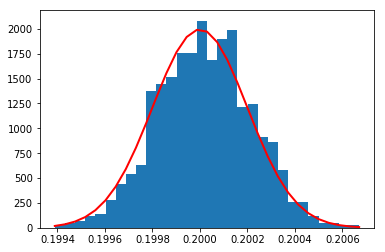

In [3]:
mu = 0.2
sigma = 0.001*mu
s = np.random.normal(mu, sigma, 1000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()

# Single events
Generate 1 event with 1000 particles, and look at the 1 dim. distributions. The distribution is shifted randomly by symmetry plane in each event. **need fix in the plotting function, not made for the shift yet.**

## $dN/d\phi$ & $dN/d\eta$

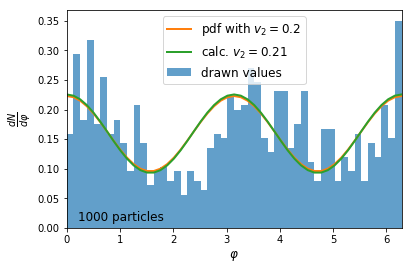

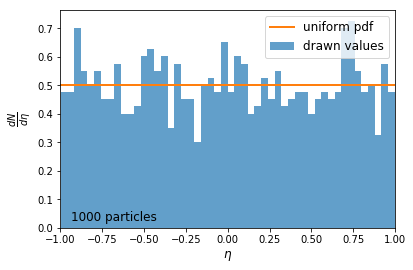

In [4]:
parts = next(event_gen_flow(1000, 1))
w = np.full_like(parts[:,1],1.0)

plotEta(parts,w)
plotPhi(parts,w)

## 2D hits of single event
2D representations of a 
- normal event
- event with non-uniform acceptance

(6000,)
(6000,)


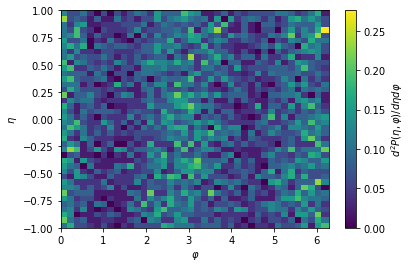

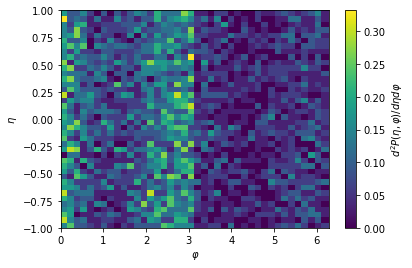

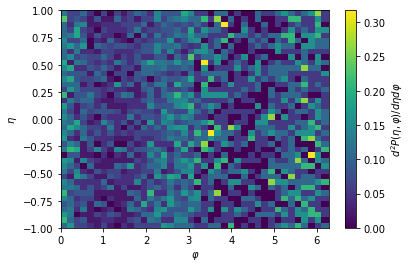

In [5]:
parts = next(event_gen_flow(6000, 1))
w = np.full_like(parts[:,0],1.)
print parts[:,0].shape
print w.shape
hist, x_edges, y_edges = np.histogram2d(parts[:, 0], parts[:, 1],weights=w, bins=[40, 40],normed=False)
hist /= np.sum(hist, dtype=np.float32) * (x_edges[1] - x_edges[0]) * (y_edges[1] - y_edges[0])
plt.pcolormesh(y_edges, x_edges, hist)
plt.colorbar(label=r"$d^2P(\eta, \varphi) / d\eta d\varphi$")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$\varphi$")
plt.savefig('2Dparticles_6000.pdf',bbox_inches='tight')
plt.show()


weights = np.full_like(parts[:,0],1.)
    
index = np.where((parts[:,1] > np.pi))
weights[index] = 0.4

for i in range(0,len(weights[:])):
    if (random.random() > weights[i]):
        parts[i,0] = -2.0
        
particles = parts[np.logical_and(-1 <= parts[:, 0], parts[:, 0] < 1)]
        #print 'after removal, no particles = ',len(particles)
w = np.full_like(particles[:,0],1.)
hist, x_edges, y_edges = np.histogram2d(particles[:, 0], particles[:, 1],weights=w, bins=[40, 40],normed=False)
hist /= np.sum(hist, dtype=np.float32) * (x_edges[1] - x_edges[0]) * (y_edges[1] - y_edges[0])

plt.pcolormesh(y_edges, x_edges, hist)
plt.colorbar(label=r"$d^2P(\eta, \varphi) / d\eta d\varphi$")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$\varphi$")
plt.savefig('2Dparticles_smeared_6000.pdf',bbox_inches='tight')

plt.show()


new_index = np.where((particles[:,1] > np.pi))
w[new_index] = 1.0/0.4

hist, x_edges, y_edges = np.histogram2d(particles[:, 0], particles[:, 1],weights=w, bins=[40, 40],normed=False)


hist /= np.sum(hist, dtype=np.float32) * (x_edges[1] - x_edges[0]) * (y_edges[1] - y_edges[0])
plt.pcolormesh(y_edges, x_edges, hist)
plt.colorbar(label=r"$d^2P(\eta, \varphi) / d\eta d\varphi$")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$\varphi$")
plt.savefig('2Dparticles_weighted_6000.pdf',bbox_inches='tight')

plt.show()


# 2 particle correlations

## Run single event

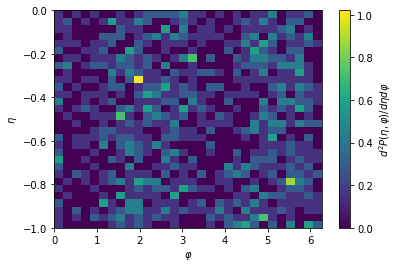

In [6]:
parts = next(event_gen_flow(2000, 1))
parts[:,0] = parts[:,0] - np.full_like(parts[:,0],1)
# Only keep particles in acceptance 0 <= eta < 3
parts = parts[np.logical_and(-1 <= parts[:, 0], parts[:, 0] < 1), :]

hist, x_edges, y_edges = np.histogram2d(parts[:, 0], parts[:, 1], [30, 30])
hist /= np.sum(hist, dtype=np.float32) * (x_edges[1] - x_edges[0]) * (y_edges[1] - y_edges[0])
plt.pcolormesh(y_edges, x_edges, hist)
plt.colorbar(label=r"$d^2P(\eta, \varphi) / d\eta d\varphi$")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$\varphi$")
plt.show()

## Run many events with 2 particle correlations
**This is the main part of the program**

In [7]:
nparts = range(500, 2000, 250)

nevents = 10
c22_true = []
c22_smear = []
p = Pool(6)
print 'nparts', nparts
print 'nevents', nevents
import time

result = []
for _ in range(1):
    start = time.time()

    args = zip(nparts, cycle([nevents]))
    print 'args', args
    result.append(p.map(calc_c22, args))
    # debug
    #result.append(calc_c22(args[0]))
    #print result
    end = time.time()
    print 'time =',(end - start)

nparts [500, 750, 1000, 1250, 1500, 1750]
nevents 10
args [(500, 10), (750, 10), (1000, 10), (1250, 10), (1500, 10), (1750, 10)]
time = 25.4479968548


## Plotting and analysis

In [8]:
a = np.array(result)
#a = a[:,0,:]

#c2, c2_smear, c2_smear_w, c2_binned_noweights, c2_binned

c22 = a[:,:,0]
c22_smear = a[:,:,1]
c22_smear_w = a[:,:,2]
c22_binned_noweights = a[:,:,3]
binned = a[:,:,4]

c22_binned = np.zeros_like(c22)
c22_binned_corr = np.zeros_like(c22)
c22_binned_corr2 = np.zeros_like(c22)
print c22.shape
print c22

for i in range(0,len(c22[:,0])):
    for j in range(0,len(c22[0,:])):
        c22[i,j] = c22[i,j]['nn2']/c22[i,j]['dn2']
        c22_smear[i,j] = c22_smear[i,j]['nn2']/c22_smear[i,j]['dn2']
        c22_smear_w[i,j] = c22_smear_w[i,j]['nn2']/c22_smear_w[i,j]['dn2']

        c22_binned_noweights[i,j] = c22_binned_noweights[i,j]['nn2']/c22_binned_noweights[i,j]['dn2']
        c22_binned[i,j] = binned[i,j]['nn2']/binned[i,j]['dn2']
        c22_binned_corr2[i,j] = binned[i,j]['nn2']/binned[i,j]['dn2']
        c22_binned_corr[i,j] = (binned[i,j]['nn2'] + binned[i,j]['auto'])/(binned[i,j]['dn2']  + binned[i,j]['auto'])

sectors = 20
c22_binned_corr2 = c22_binned_corr2*(2*np.pi/sectors)/(np.sin(2*np.pi/sectors))
c22_binned_corr3 = c22_binned_corr*(2*np.pi/sectors)/(np.sin(2*np.pi/sectors))

c22 = np.array(c22)
c22_smear = np.array(c22_smear)
c22_smear_w = np.array(c22_smear_w)
c22_binned = np.array(c22_binned)
c22_binned_noweights = np.array(c22_binned_noweights)

(1, 6)
[[{'auto': 0.0, 'nn2': 79293.26350178126, 'dn2': 2495000.0}
  {'auto': 0.0, 'nn2': 196548.73069977702, 'dn2': 5617500.0}
  {'auto': 0.0, 'nn2': 359643.5681438921, 'dn2': 9990000.0}
  {'auto': 0.0, 'nn2': 583807.2511062047, 'dn2': 15612500.0}
  {'auto': 0.0, 'nn2': 860409.463793938, 'dn2': 22485000.0}
  {'auto': 0.0, 'nn2': 1189526.2752217199, 'dn2': 30607500.0}]]


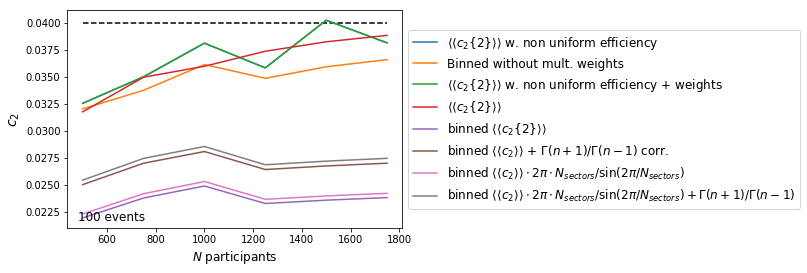

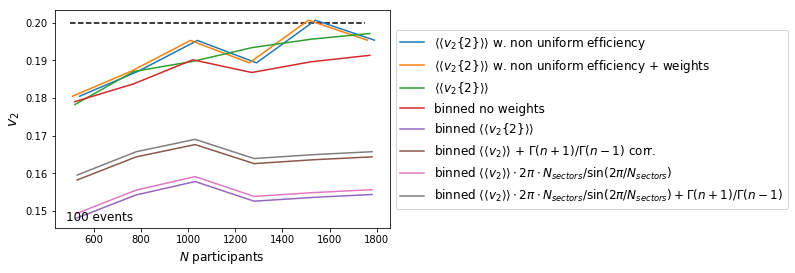

In [9]:
#plt.errorbar(nparts,np.mean(c22_true,axis=0),yerr=np.std(c22_true,axis=0),label='c2')
for i in range(0,1):
    plt.errorbar([x+0 for x in nparts],c22_smear[i],label=r'$\langle \langle c_2\{2\} \rangle \rangle$ w. non uniform efficiency') #yerr=[np.std(c22_smear[:,i])/2 for i in range(0,len(nparts))]
    plt.errorbar([x+0 for x in nparts],c22_binned_noweights[i],label=r'Binned without mult. weights') #yerr=[np.std(c22_smear[:,i])/2 for i in range(0,len(nparts))]
    plt.errorbar([x+0 for x in nparts],c22_smear_w[i],label=r'$\langle \langle c_2\{2\} \rangle \rangle$ w. non uniform efficiency + weights') #yerr=[np.std(c22_smear_w[:,i])/2 for i in range(0,len(nparts))]
    plt.errorbar([x+0 for x in nparts],c22[i],label=r'$\langle \langle c_2\{2\} \rangle \rangle$')#yerr=[np.std(c22[:,i])/2 for i in range(0,len(nparts))]
    plt.errorbar([x+0 for x in nparts],c22_binned[i],label=r'binned $\langle \langle c_2\{2\} \rangle \rangle$')
    plt.errorbar([x+0 for x in nparts],c22_binned_corr[i],label=r'binned $\langle \langle c_2 \rangle \rangle$ + $\Gamma (n+1)/\Gamma (n-1)$ corr.')
    plt.errorbar([x+0 for x in nparts],c22_binned_corr2[i],label=r'binned $\langle \langle c_2 \rangle \rangle \cdot 2 \pi \cdot N_{sectors}/\sin (2 \pi / N_{sectors}) $')
    plt.errorbar([x+0 for x in nparts],c22_binned_corr3[i],label=r'binned $\langle \langle c_2 \rangle\rangle \cdot 2 \pi \cdot N_{sectors}/ \sin(2 \pi / N_{sectors}) + \Gamma (n+1)/\Gamma (n-1)$')

#plt.errorbar([x+30 for x in nparts],np.mean(c22_binned,axis=0),yerr=[np.std(c22_binned[:,i])/2 for i in range(0,len(nparts))],label='binned')
#plt.errorbar([x+40 for x in nparts],np.mean(c22_binned_corr,axis=0),yerr=[np.std(c22_binned_corr[:,i])/2 for i in range(0,len(nparts))],label='binned corr.')
plt.ylabel(r'$c_2$',fontsize=14)
plt.xlabel(r'$N$ participants',fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.plot(nparts, [0.04]*len(nparts), 'k--')
plt.gcf().text(0.15,0.15,'100 events',fontsize=12)
plt.savefig('GF_study_c2_nevents100.pdf',bbox_inches='tight')
#plt.savefig('dNdeta.pdf',bbox_inches='tight')

plt.show()

v22_smear = np.power(c22_smear,0.5)
v22_smear_w = np.power(c22_smear_w,0.5)
v22= np.power(c22,0.5)
v22_binned = np.power(c22_binned,0.5)
v22_binned_corr = np.power(c22_binned_corr,0.5)
v22_binned_corr2 = np.power(c22_binned_corr2,0.5)
v22_binned_corr3 = np.power(c22_binned_corr3,0.5)
v22_binned_noweights = np.power(c22_binned_noweights,0.5)



#plt.errorbar(nparts,np.mean(v22,axis=0),yerr=np.std(v22,axis=0),label='c2')
plt.errorbar([x+40 for x in nparts],np.mean(v22_smear,axis=0),label=r'$\langle \langle v_2\{2\} \rangle \rangle$ w. non uniform efficiency')
plt.errorbar([x+10 for x in nparts],np.mean(v22_smear_w,axis=0),label=r'$\langle \langle v_2\{2\} \rangle \rangle$ w. non uniform efficiency + weights')
plt.errorbar([x+20 for x in nparts],np.mean(v22,axis=0), label=r'$\langle \langle v_2\{2\} \rangle \rangle$')
plt.errorbar([x+20 for x in nparts],np.mean(v22_binned_noweights,axis=0), label=r'binned no weights')
plt.errorbar([x+30 for x in nparts],np.mean(v22_binned,axis=0),label=r'binned $\langle \langle v_2\{2\} \rangle \rangle$')
plt.errorbar([x+30 for x in nparts],np.mean(v22_binned_corr,axis=0),label=r'binned $\langle \langle v_2 \rangle \rangle$ + $\Gamma (n+1)/\Gamma (n-1)$ corr.')
plt.errorbar([x+30 for x in nparts],np.mean(v22_binned_corr2,axis=0),label=r'binned $\langle \langle v_2 \rangle \rangle \cdot 2 \pi \cdot N_{sectors}/\sin (2 \pi / N_{sectors}) $')
plt.errorbar([x+30 for x in nparts],np.mean(v22_binned_corr3,axis=0),label=r'binned $\langle \langle v_2 \rangle\rangle \cdot 2 \pi \cdot N_{sectors}/ \sin(2 \pi / N_{sectors}) + \Gamma (n+1)/\Gamma (n-1)$')


plt.ylabel(r'$v_2$',fontsize=14)
plt.xlabel(r'$N$ participants',fontsize=12)
#plt.legend(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

plt.plot(nparts, [0.2]*len(nparts), 'k--')
#plt.ylim([0,0.3])
plt.gcf().text(0.15,0.15,'100 events',fontsize=12)
#plt.savefig('dNdeta.pdf',bbox_inches='tight')
plt.savefig('GF_study_v2_nevents100.pdf',bbox_inches='tight')
#plt.ylim([0,0.3])
#plt.ylim([0,0.3])

plt.show()

# Tests
## test binned particles

In [10]:
#parts, w = makeBinnedParticles(parts,5,5)
#print parts
#print w